# Financial Econometrics and Machine Learning

Urkesh Cusack, Uyc2, Yale University

In [1]:
import pandas as pd
import numpy as np
import math
import statistics
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats
import scipy
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import norm, uniform, skew, kurtosis
from sklearn.metrics import r2_score
import statsmodels.api as sm

#

FF BEME ratio. where BE is the compustat book value of stockholders equity plus balance-sheet deffered taxes and investment tax credit minus the book value of preferred stock. (E.F. Fama and K.R. French, 1993, Common risk factors in stock and bond returns.) To run this portfolio we will use the following process: 
<br />
<br />
<br />
- Step 1: import variables from wrds
  - gvkey (stock id)
  - datadate
  - book value of stockholders equity (seq)
  - deferred taxes and investment tax credit (txditc)
  - book value of prefferred stock (pstk)
  - share price at end of quarter (prccq)
  - market equity (common shares outstanding * share price) **    
<br />
<br />
<br />

- Step 2: Calculate BEME ratio
  - (book val. of stockholders equity + deferred taxes and investment tax credit - book value of preferred stock) / market equity 
  - (seq + txditc - pstk) / market_equity 
<br />
<br />
<br />


- Step 3: Sort by date, then by BEME ratio 
  - take whole dataset, group by date, within each date create a BEME ranking
<br /> 
<br />
<br />

- Step 4: Create BEME portfolio 30/30
  - create a long short portfolio for each quarter.
  - long the top 30% percentile of stocks as per their beme ratio
    - weighted average return of all stocks in top 30% percentile 
  - short the bottom 30% percentile of stocks as per their beme ratio
    - weighted average return of all stocks in bottom 30% percentile 
  - create a L/S portfolio at each quarter, which return = long_portfolio - short_portfolio
<br />
<br />
<br />

- Step 5: Track BEME returns
  - compute the cumulative return of the portfolio with quarterly rebalance 
  - plot returns
<br />
<br />
<br />
<br />
<br />


<span style="font-size: smaller;">_One challenge in computing market equity is accounting for stock splits and share dilutions. These events change the number of outstanding shares, affecting calculations of market capitalization and stock returns. While Compustat provides share price data, it does not offer quarterly stock returns, necessitating manual computation. I Attempted mapping between CRSP's "permno" and Compustat's "gvkey" identifiers but it didn't work properly, leading to mismatches. Therefore, calculating returns by comparing end-of-period Compustat prices is the best solution I can provide at this point. Despite the potential issues with stock splits and dilutions, their impact may be mitigated in large datasets where such events are relatively infrequent. Additionally, a diversified portfolio with numerous stocks can help to buffer the effect of any single company's structural changes on the aggregate market equity computation_</span>



#

# Question 1: reate the Fama-French version of the book-to-market equity ratio. 

# Download and import accounting data (earnings and market equity) from WRDS to create the BEME metric 

Data imports

In [3]:
pip install wrds

Note: you may need to restart the kernel to use updated packages.


In [11]:
import wrds
db = wrds.Connection(wrds_username="urkesh")
db.create_pgpass_file()

Loading library list...
Done


Enter your WRDS username [urkesh]: urkesh
Enter your password: ········


#

# Step 1: Import variables from wrds

In [47]:
db = wrds.Connection()

try:
    # SQL query to retrieve the required data
    query = """
    WITH RankedData AS (
        SELECT 
            gvkey AS stock,
            datadate AS date,
            ceqq AS book_equity,
            txditcq AS deferred_taxes,
            pstkq AS book_value_preferred,  -- Assuming pstkq represents book value preferred
            prccq AS share_price,
            cshoq AS shares_outstanding,
            cshoq * prccq AS market_cap,
            RANK() OVER (PARTITION BY DATE_TRUNC('quarter', datadate) ORDER BY cshoq * prccq DESC) AS mc_rank
        FROM 
            comp.fundq
        WHERE 
            datadate BETWEEN '1954-01-01' AND '2022-12-31'
            AND cshoq IS NOT NULL 
            AND prccq IS NOT NULL
    )
    SELECT
        stock,
        date,
        book_equity,
        deferred_taxes,
        book_value_preferred,
        share_price,
        shares_outstanding
    FROM 
        RankedData
    WHERE
        mc_rank <= 3000;
    """

    data = db.raw_sql(query)

    print(data.head())

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    db.close()


Enter your WRDS username [urkes]: urkesh
Enter your password: ········


WRDS recommends setting up a .pgpass file.


Create .pgpass file now [y/n]?:  y


Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done
    stock        date  book_equity  deferred_taxes  book_value_preferred  \
0  002024  1962-03-31          NaN             NaN                   NaN   
1  003066  1962-03-31      849.684             NaN                   0.0   
2  002943  1962-03-31      758.153             NaN                   0.0   
3  007562  1962-03-31      580.904             NaN                   NaN   
4  002968  1962-03-31      445.286             NaN                   NaN   

   share_price  shares_outstanding  
0    55.631974              28.480  
1   102.211098              12.734  
2    80.499985              13.968  
3   139.749837               7.540  
4    91.749933               8.477  


In [48]:
data.to_csv("data_create_beme")

In [49]:
data = pd.read_csv("data_create_beme")

#

# Step 2: Calculate BEME Ratio


(book val. of stockholders equity + deferred taxes and investment tax credit - book value of preferred stock) / market equity

(seq + txditc - pstk) / market_equity

In [50]:
#book equity (millions)
#deffered taxes (millions)
#book value preffered (millions)
#share price (dollar ammount) 
#shares outstanding (millions)
#market_cap (millions)
data = data.dropna(subset=['book_equity'])
data['real_book_eq'] = data['book_equity'].add(data['deferred_taxes'], fill_value=0)\
                                          .sub(data['book_value_preferred'], fill_value=0)

data['market_cap'] = data['share_price'] * data['shares_outstanding']
data

,Unnamed: 0,stock,date,book_equity,deferred_taxes,book_value_preferred,share_price,shares_outstanding,real_book_eq,market_cap
1,1,3066,1962-03-31,849.684,NaN,0.0,102.211098,12.734,849.684,1301.556117
2,2,2943,1962-03-31,758.153,NaN,0.0,80.499985,13.968,758.153,1124.423787
3,3,7562,1962-03-31,580.904,NaN,NaN,139.749837,7.540,580.904,1053.713768
4,4,2968,1962-03-31,445.286,NaN,NaN,91.749933,8.477,445.286,777.764184
5,5,7003,1962-03-31,461.912,NaN,0.0,56.499823,11.719,461.912,662.121423
...,...,...,...,...,...,...,...,...,...,...
621368,121368,31368,2022-12-31,637.515,NaN,0.0,24.750000,30.486,637.515,754.528500
621369,121369,12379,2022-10-31,829.179,34.454,0.0,45.350000,16.622,863.633,753.807700
621370,121370,15212,2022-12-31,52.977,10.588,0.0,19.830000,37.938,63.565,752.310540
621371,121371,39215,2022-12-31,165.890,3.508,0.0,20.140000,37.332,169.398,751.866480


In [53]:
#create beme ratio 
data['beme'] = data['real_book_eq'] / data['market_cap']
data

,Unnamed: 0,stock,date,book_equity,deferred_taxes,book_value_preferred,share_price,shares_outstanding,real_book_eq,market_cap,beme
1,1,3066,1962-03-31,849.684,NaN,0.0,102.211098,12.734,849.684,1301.556117,0.652822
2,2,2943,1962-03-31,758.153,NaN,0.0,80.499985,13.968,758.153,1124.423787,0.674259
3,3,7562,1962-03-31,580.904,NaN,NaN,139.749837,7.540,580.904,1053.713768,0.551292
4,4,2968,1962-03-31,445.286,NaN,NaN,91.749933,8.477,445.286,777.764184,0.572521
5,5,7003,1962-03-31,461.912,NaN,0.0,56.499823,11.719,461.912,662.121423,0.697624
...,...,...,...,...,...,...,...,...,...,...,...
621368,121368,31368,2022-12-31,637.515,NaN,0.0,24.750000,30.486,637.515,754.528500,0.844918
621369,121369,12379,2022-10-31,829.179,34.454,0.0,45.350000,16.622,863.633,753.807700,1.145694
621370,121370,15212,2022-12-31,52.977,10.588,0.0,19.830000,37.938,63.565,752.310540,0.084493
621371,121371,39215,2022-12-31,165.890,3.508,0.0,20.140000,37.332,169.398,751.866480,0.225303


In [64]:
# let us drop all the beme below -50 and above 50 as it doesn't make much ssense and might be some outlier errors of the data or the compustat database. Also drop market cap where market cap is below 100,000 as it doesn't make much sense aswell. 
data = data[(data['beme'] >= -50) & (data['beme'] <= 100)]
data = data[data['market_cap'] >= 0.1]

#

# Step 3: Sort by date, then by BEME ratio

In [61]:
# sort by date, wihtin each date, sort by beme
data = data.sort_values(by=['date', 'beme'], ascending=[True, False])


,stock,date,book_equity,deferred_taxes,book_value_preferred,share_price,shares_outstanding,real_book_eq,market_cap,beme
27,8245,1962-03-31,98.432,NaN,NaN,39.250000,3.026,98.432,118.770500,0.828758
30,7005,1962-03-31,62.554,NaN,NaN,53.999799,1.410,62.554,76.139717,0.821569
28,3231,1962-03-31,92.312,NaN,NaN,59.499765,1.930,92.312,114.834547,0.803870
17,4682,1962-03-31,178.482,NaN,NaN,64.250000,3.470,178.482,222.947500,0.800556
32,1999,1962-03-31,56.943,NaN,NaN,48.999939,1.542,56.943,75.557906,0.753634
...,...,...,...,...,...,...,...,...,...,...
620659,18036,2022-12-31,-1546.000,173.4,1100.3,7.350000,208.371,-2472.900,1531.526850,-1.614663
620828,23077,2022-12-31,-2273.577,0.0,0.0,5.530000,235.829,-2273.577,1304.134370,-1.743361
621056,33433,2022-12-31,-3670.000,0.0,0.0,1.430000,708.163,-3670.000,1012.673090,-3.624072
620400,4601,2022-12-31,-79689.000,0.0,139966.0,0.353400,5858.088,-219655.000,2070.248299,-106.100800


#

# Question 2: Create a dataset of monthly return data. 

In [77]:
data = data.sort_values(by=['stock', 'date'], ascending=[True, True])
data['return'] = data.groupby('stock')['share_price'].pct_change()
data = data.groupby('stock').apply(lambda group: group.iloc[1:-1]).reset_index(drop=True)

,stock,date,book_equity,deferred_taxes,book_value_preferred,share_price,shares_outstanding,real_book_eq,market_cap,beme,return
0,1000,1972-06-30,6.646,NaN,0.0,6.000,2.956,6.646,17.73600,0.374718,0.066667
1,1000,1972-09-30,7.176,NaN,0.0,5.250,2.959,7.176,15.53475,0.461932,-0.125000
2,1000,1972-12-31,7.021,0.288,0.0,5.125,2.902,7.309,14.87275,0.491436,-0.023810
3,1000,1973-03-31,7.615,NaN,0.0,4.375,3.050,7.615,13.34375,0.570679,-0.146341
4,1000,1973-06-30,8.041,NaN,0.0,3.000,3.029,8.041,9.08700,0.884891,-0.314286
...,...,...,...,...,...,...,...,...,...,...,...
491786,339965,2021-10-31,5006.682,0.000,0.0,353.840,305.899,5006.682,108239.30216,0.046256,0.331627
491787,339965,2022-01-31,5049.045,NaN,0.0,275.900,312.377,5049.045,86184.81430,0.058584,-0.220269
491788,345980,2021-09-30,829.000,NaN,0.0,5.460,635.000,829.000,3467.10000,0.239105,-0.585421
491789,347007,2021-12-31,-242.173,0.162,0.0,6.080,397.830,-242.011,2418.80640,-0.100054,-0.375770


In [159]:
summary_statistics = data['return'].describe()
print(summary_statistics)

count    491791.000000
mean          0.033979
std           0.392515
min          -0.999181
25%          -0.092031
50%           0.017211
75%           0.130512
max          52.027778
Name: return, dtype: float64


#

# Question 3: Create a monthly return series of the HML factor and plot cumulative return

# Step 4: Create Long Short Portfolio

In [121]:
#create the portfolio. long bottom 30% at each date, short top 30% at each date. 
def calc_diff_in_avg_returns(group):    
    sorted_group = group.sort_values(by='beme')
    #Determine the top and bottom 30% threshold
    top_bottom_threshold = int(len(sorted_group) * 0.3)
    # Calculate the average return for the top and bottom 30%
    avg_return_top = sorted_group[-top_bottom_threshold:]['return'].mean()
    avg_return_bottom = sorted_group[:top_bottom_threshold]['return'].mean()
    
    return avg_return_bottom - avg_return_top 

portfolio_returns = data.groupby('date').apply(calc_diff_in_avg_returns)

#data = data.merge(portfolio_returns.rename('portfolio_return'), on='date', how='left')


In [124]:
portfolio_returns

date
1962-12-31    0.033663
1963-03-31    0.074228
1963-06-30   -0.056733
1963-09-30   -0.025828
1963-12-31   -0.028673
                ...   
2021-11-30    0.143569
2021-12-31    0.038138
2022-01-31   -0.137929
2022-02-28   -0.023120
2022-03-31   -0.145353
Length: 664, dtype: float64

In [125]:
#test with first quarter to see if method is correct. 
test_sample = data[:30].sort_values(by="beme", ascending=False)
top_30_count = int(len(test_sample) * 0.3)
top_30_sample = test_sample.head(top_30_count)
print(top_30_sample['return'].mean())

test_sample_lowhigh =data[:30].sort_values(by="beme", ascending=True)

bottom_30_count = int(len(test_sample_lowhigh) * 0.3)
bottom_30_sample = test_sample_lowhigh.head(bottom_30_count)
print(bottom_30_sample['return'].mean())

0.08376325479978723
0.1174264902551282


In [126]:
0.1174264902551282-0.08376325479978723

0.03366323545534097

#

# Step 5: Track BEME returns

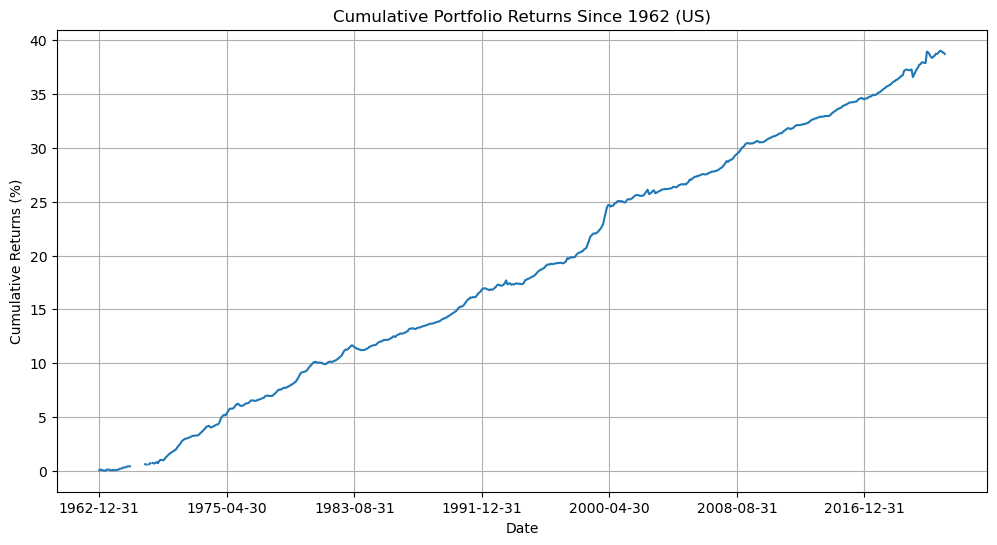

In [131]:
cumulative_returns = portfolio_returns.cumsum()

plt.figure(figsize=(12, 6))
cumulative_returns.plot()
plt.title('Cumulative Portfolio Returns Since 1962 (US)')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns (%)')
plt.grid(True)
plt.show()

#

#

# Question 4: Compare and contrast the HML factors with book-to-market portfolios from Jensen et al. (2021)

In [165]:
jensen = pd.read_csv("C:\FinancialEcon Machine Learning\[usa]_[be_me]_[monthly]_[vw_cap].csv")
jensen

,location,name,freq,weighting,direction,n_stocks,n_stocks_min,date,ret
0,usa,be_me,monthly,vw_cap,1,13,4,1950-11-30,0.050720
1,usa,be_me,monthly,vw_cap,1,16,6,1950-12-31,0.045273
2,usa,be_me,monthly,vw_cap,1,21,8,1951-01-31,0.014959
3,usa,be_me,monthly,vw_cap,1,30,12,1951-02-28,-0.015404
4,usa,be_me,monthly,vw_cap,1,39,17,1951-03-31,0.018392
...,...,...,...,...,...,...,...,...,...
861,usa,be_me,monthly,vw_cap,1,3286,1156,2022-08-31,0.001046
862,usa,be_me,monthly,vw_cap,1,3248,1159,2022-09-30,-0.014072
863,usa,be_me,monthly,vw_cap,1,3247,1141,2022-10-31,0.038290
864,usa,be_me,monthly,vw_cap,1,3267,1118,2022-11-30,0.009311


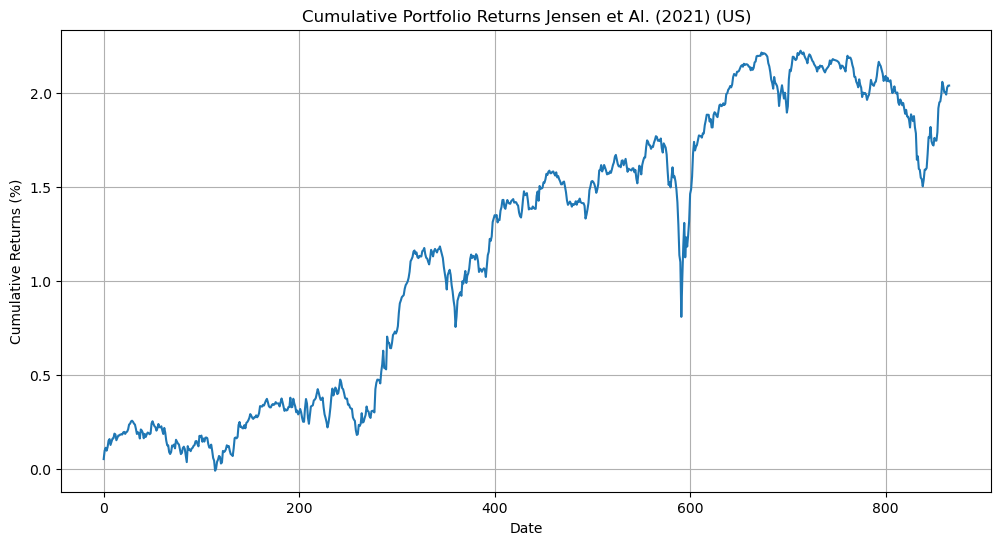

In [166]:
cumulative_returns_jensen = jensen['ret'].cumsum()

plt.figure(figsize=(12, 6))
cumulative_returns_jensen.plot()
plt.title('Cumulative Portfolio Returns Jensen et Al. (2021) (US)')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns (%)')
plt.grid(True)
plt.show()

Jensen et al's portfolio appears to represent a more short-term view with a more volatile return path. For both portfolios, the overall trend is upward, which is typical for equity markets over extended periods. The main differences, might be due to the fact that Jensen et al. approach may differ in how the portfolios are weighted or constructed, especially in the weighting of the stocks, additionally, I think that the universe of stocks considered and the rebalancing frequency, can affect the performance comparison. 